In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output

In [2]:
data = pd.read_csv('Sentiment.csv')
data = data[['text', 'sentiment']]

In [3]:
data.head()

,text,sentiment
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive


In [4]:
#Spliting the dataset into train and test set
train, test = train_test_split(data, test_size=0.1, random_state=0)
#Removing neutral sentiments as the goal is to diferentiate only the positive and negative tweets
train = train[train.sentiment != 'Neutral']

Positive words


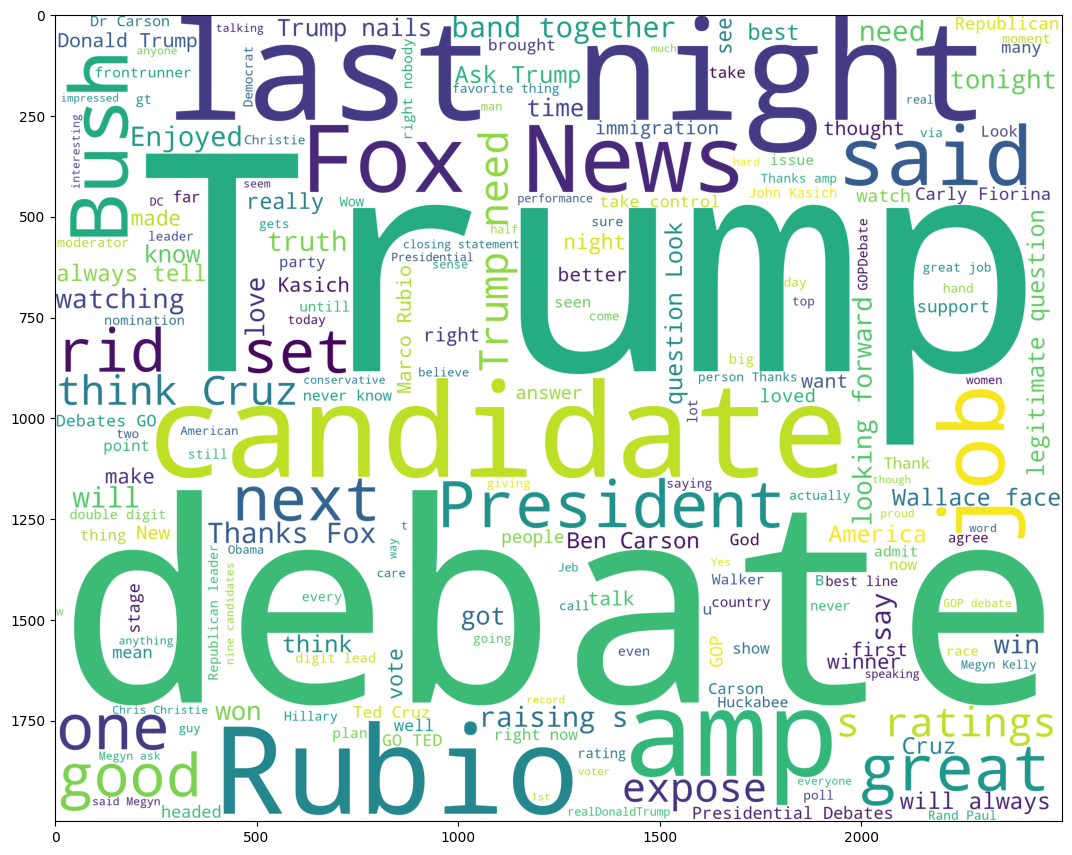

Negative words


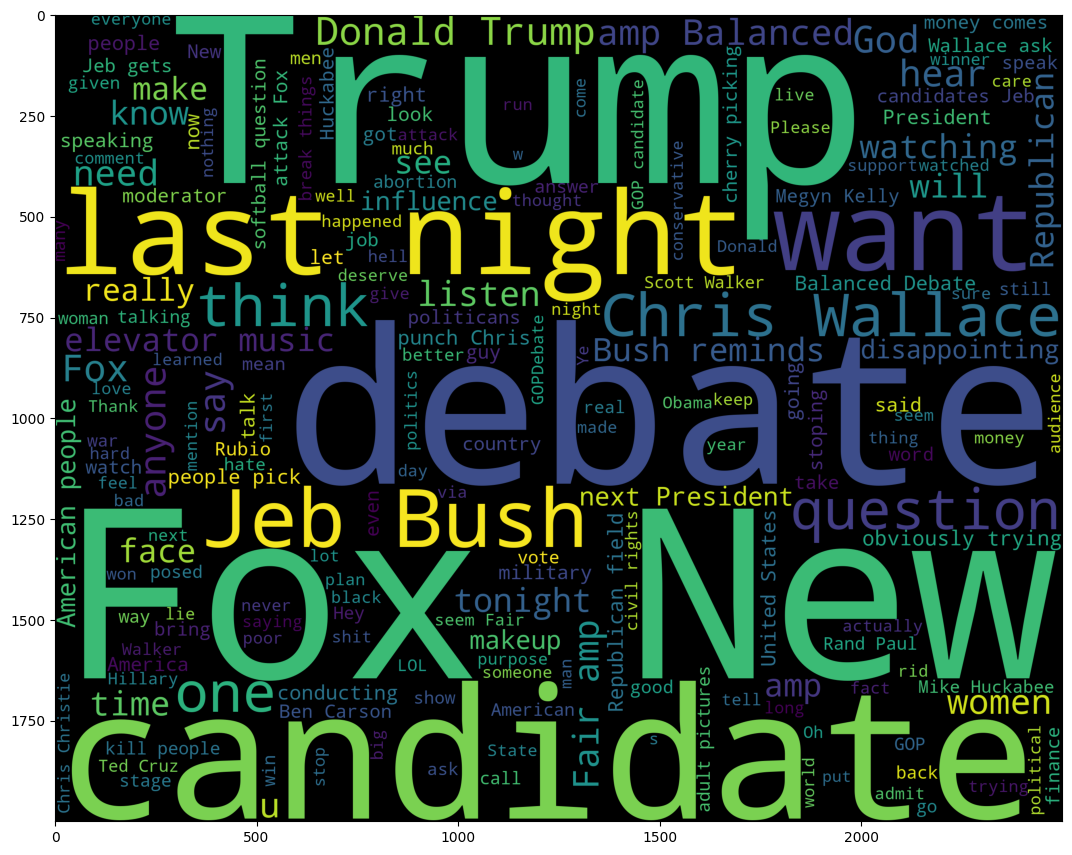

In [5]:
#Cleaning and visualization
train_pos = train[train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color='black'):
    words = ' '.join(data)
    cleaned_word = ' '.join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color=color,
                          width=2500,
                          height=2000
                         ).generate(cleaned_word)
    plt.figure(1, figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.show()

print("Positive words")
wordcloud_draw(train_pos, 'white')
print("Negative words")
wordcloud_draw(train_neg)

In [6]:
#Removing hashtags, mentions, links and stopwords(the, for, this etc.)
tweets = []
stopwords_set = set(stopwords.words('english'))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e)>=3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
            and not word.startswith('@')
            and not word.startswith('#')
            and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_without_stopwords, row.sentiment))
    

In [7]:
test_pos = test[test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [8]:
#Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features

w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['contains(%s)' % word] = (word in document_words)
    return features
    

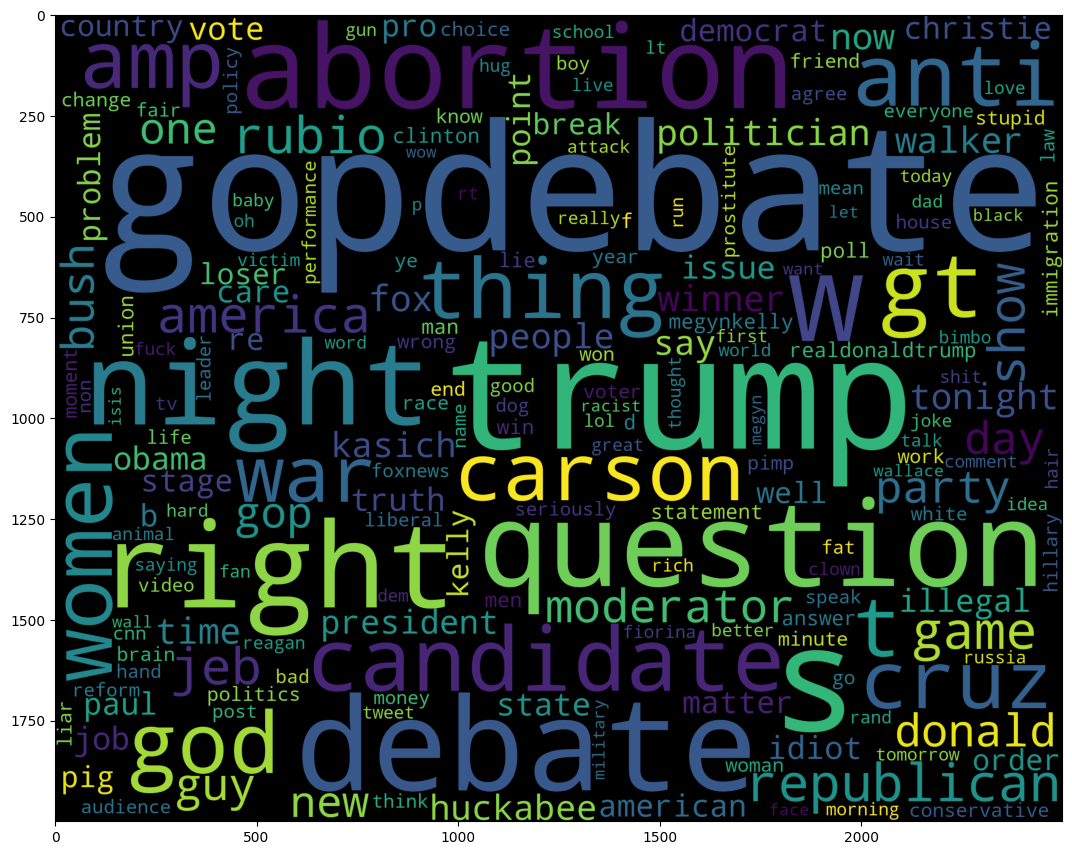

In [9]:
wordcloud_draw(w_features)

In [10]:
#Using the NLTK Naive Bayes classifier to classify the extracted tweet word features
training_set = nltk.classify.apply_features(extract_features, tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [11]:
neg_cnt = 0
pos_cnt = 0

for obj in test_neg:
    res = classifier.classify(extract_features(obj.split()))
    if (res == 'Negative'):
        neg_cnt += 1

for obj in test_pos:
    res = classifier.classify(extract_features(obj.split()))
    if (res == 'Positive'):
        pos_cnt += 1

print('[Negative]: %s/%s ' % (len(test_neg), neg_cnt))
print('[Positive]: %s/%s ' % (len(test_pos), pos_cnt))

[Negative]: 819/772 
[Positive]: 226/103 
